In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from scipy.stats import spearmanr

In [2]:
def get_data_1(selected_num) :
    # Load the dataset using Pandas
    data = pd.read_csv('energy_efficiency_data.csv')

    # Shuffle the dataset
    data = data.sample(frac=1, random_state=42)

    # Split data into training and testing sets

    X = data.drop(['Heating Load', 'Cooling Load'], axis=1)
    X = pd.get_dummies(X, columns=['Orientation', 'Glazing Area Distribution'])
    Y = data['Heating Load']

    # Calculate Pearson correlation coefficients between features and target
    correlations = []
    for feature in X.columns:
        correlation, _ = spearmanr(X[feature], Y)
        correlations.append((feature, correlation))

    # Sort features by absolute correlation
    sorted_correlations = sorted(correlations, key=lambda x: x[1], reverse=True)

    # Choose the top N features with highest correlation
    num_selected_features = selected_num  # You can adjust the number of selected features
    selected_features = [feature for feature, _ in sorted_correlations[:num_selected_features]]

    # Subset the data with selected features
    X_selected = X[selected_features]

    X_train, X_test, Y_train, Y_test = train_test_split(X_selected, Y, test_size=0.25, random_state=42)

    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    return X_train, Y_train, X_test, Y_test


In [3]:
def sigmoid(x, der):
    if der: 
        return np.exp(-x) / ((1 + np.exp(-x)) ** 2)
    else:
        return 1 / (1 + np.exp(-x))

def relu(x, der):
    if der: 
        return np.where(x > 0, 1, 0)
    else:
         return np.maximum(0, x)
    
def linear(x, der):
    if der:
        return 1
    else:
        return x

def tanh(x, der):
    if der:
        return (1 - np.power(np.tanh(x), 2))
    else:
        return np.tanh(x)
    
def softmax(x, der):
    
    if len(x.shape) > 1:
        axis = -2  # Choose the second-to-last axis for 2D input
    else:
        axis = -1  # Default to the last axis for 1D input

    e_x = np.exp(x - np.max(x, axis=axis, keepdims=True))
    softmax_output = e_x / e_x.sum(axis=axis, keepdims=True)

    if der:
        return 1
    else:
        return softmax_output

In [4]:
def init_layers(nn_architecture):
    parameters = {}
    for i, layer in enumerate(nn_architecture):
        layer_input_size = layer['input_size']
        layer_output_size = layer['output_size']
        parameters[f'W{i}'] = np.random.randn(layer_output_size, layer_input_size)
        parameters[f'b{i}'] = np.zeros((layer_output_size, 1))
    return parameters

In [5]:
def forward_propagation(X, parameters, nn_architecture):
    cache = {}
    A = X
    cache[f'X'] = X
    for i, layer in enumerate(nn_architecture):
        W = parameters[f'W{i}']
        b = parameters[f'b{i}']
        Z = np.dot(W, A) + b
        A = nn_architecture[i]['activation'](Z, False)
        cache[f'Z{i}'] = Z
        cache[f'A{i}'] = A
    return A, cache

# Backward propagation
def backward_propagation(Y_hat, Y, cache, parameters, nn_architecture, loss_function):
    grads = {}
    m = Y.shape[1]  # Number of training examples
    
    for i in reversed(range(len(nn_architecture))):
        Z = cache[f'Z{i}']
        act_z = nn_architecture[i]['activation'](Z, True)
        if i == len(nn_architecture) - 1:  # Output layer
            dC = loss_function(Y, Y_hat, True) * act_z
        else:  # Hidden layer
            dC_next = dC
            W_next = parameters.get(f'W{i+1}')
            dC = np.dot(W_next.T, dC_next) * act_z

        A_prev = cache.get(f'A{i-1}') if i > 0 else cache.get(f'X')
        grads[f'dW{i}'] = (1 / m) * np.dot(dC, A_prev.T)
        grads[f'db{i}'] = (1 / m) * np.sum(dC, axis=1, keepdims=True)
    return grads

In [6]:
# Loss function (MSE for regression)
def sum_of_square(Y, Y_hat, der):
    if der:
        return Y_hat-Y
    else:
        return np.mean((Y_hat - Y) ** 2)

def cross_entropy(Y, Y_hat, der):
    epsilon = 1e-15
    m = Y_hat.shape
    if m[0] == 1:
        if der:
            loss = Y_hat-Y
        else:
            loss = -np.mean(Y * np.log(Y_hat + epsilon) + (1 - Y) * np.log(1 - Y_hat + epsilon))
    elif m[0] == 2:
        if der:
            Y_hat[Y, range(m[1])] -= 1
            loss = Y_hat
        else:
            loss = -np.mean(np.log(Y_hat[Y, range(m[1])] + epsilon))
    else:
        print("The class num is wrong")
    return loss

# Update weights and biases
def update(parameters, grads, nn_architecture, learning_rate):
    for i, layer in enumerate(nn_architecture):
        parameters[f'W{i}'] -= learning_rate * grads[f'dW{i}']
        parameters[f'b{i}'] -= learning_rate * grads[f'db{i}']
    return parameters

In [7]:
# Training process with loss tracking
def train(X, Y, nn_architecture, loss_function, epochs, learning_rate):
    parameters = init_layers(nn_architecture)
    loss_history = []  # To store the loss for each epoch
    
    for i in range(epochs):
        if (i == 20): cache20 = cache
        Y_hat, cache = forward_propagation(X, parameters, nn_architecture)
        loss = loss_function(Y, Y_hat, False)
        loss_history.append(loss)
        grads = backward_propagation(Y_hat, Y, cache, parameters, nn_architecture, loss_function)
        parameters = update(parameters, grads, nn_architecture, learning_rate)
    return parameters, loss_history, cache20


In [8]:
X_train, Y_train, X_test, Y_test = get_data_1(4)
# Define the neural network architecture for regression
nn_architecture = [
    {'input_size': X_train.shape[1], 'output_size': 64, 'activation': relu},
    {'input_size': 64, 'output_size': 32, 'activation': relu},
    {'input_size': 32, 'output_size': 1, 'activation': linear}  # Linear activation for regression
]
# Train the neural network and collect loss history
trained_parameters, loss_history, cache20 = train(X_train.T, Y_train.values.reshape(1, -1), nn_architecture, sum_of_square, epochs=1000, learning_rate=0.001)


Training RMS Error: 0.6432678215421948
Testing RMS Error: 0.6740048621371999


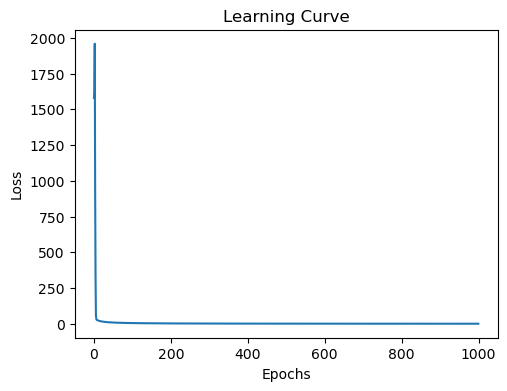

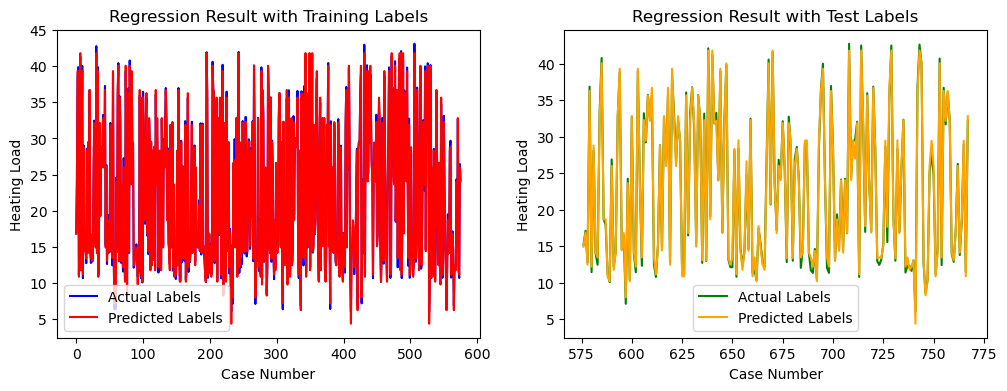

In [9]:
# Predict on training and testing data
Y_train_pred, _ = forward_propagation(X_train.T, trained_parameters, nn_architecture)
Y_test_pred, _ = forward_propagation(X_test.T, trained_parameters, nn_architecture)

# Calculate RMS error for training and testing data
train_rms_error = np.sqrt(np.mean((Y_train_pred - Y_train.values.reshape(1, -1)) ** 2))
test_rms_error = np.sqrt(np.mean((Y_test_pred - Y_test.values.reshape(1, -1)) ** 2))

print(f"Training RMS Error: {train_rms_error}")
print(f"Testing RMS Error: {test_rms_error}")

# Plot the learning curve (loss over epochs)
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(range(len(loss_history)), loss_history)
plt.title("Learning Curve")
plt.xlabel("Epochs")
plt.ylabel("Loss")

# Create a list of case numbers
case_numbers_train = range(len(Y_train))
case_numbers_test = range(len(Y_train), len(Y_train) + len(Y_test))

# Create a line plot for training labels and predictions
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(case_numbers_train, Y_train, label="Actual Labels", color="blue")
plt.plot(case_numbers_train, Y_train_pred[0], label="Predicted Labels", color="red")
plt.xlabel("Case Number")
plt.ylabel("Heating Load")
plt.title("Regression Result with Training Labels")
plt.legend()

# Create a line plot for test labels and predictions
plt.subplot(1, 2, 2)
plt.plot(case_numbers_test, Y_test, label="Actual Labels", color="green")
plt.plot(case_numbers_test, Y_test_pred[0], label="Predicted Labels", color="orange")
plt.xlabel("Case Number")
plt.ylabel("Heating Load")
plt.title("Regression Result with Test Labels")
plt.legend()

plt.show()


In [10]:
def get_data_2() :
    # Load the Ionosphere dataset (replace 'ionosphere_data.csv' with the actual file name)
    data = pd.read_csv('ionosphere_data.csv')

    data.iloc[:, -1] = data.iloc[:, -1].apply(lambda x: 1 if x == 'g' else 0)
    # Split data into features and labels
    X = data.iloc[:, :-1].values  # All columns except the last one
    Y = data.iloc[:, -1].values.astype(np.int8)   # The last column

    # Split data into training and testing sets (80% for training, 20% for testing)
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
    return X_train, Y_train, X_test, Y_test

In [18]:
X_train, Y_train, X_test, Y_test = get_data_2()
# Define the neural network architecture for regression
nn_architecture = [
    {'input_size': X_train.shape[1], 'output_size': 64, 'activation': tanh},
    {'input_size': 64, 'output_size': 32, 'activation': tanh},
    {'input_size': 32, 'output_size': 2, 'activation': tanh},
    {'input_size': 2, 'output_size': 2, 'activation': softmax}  # Linear activation for regression
]
# Train the neural network and collect loss history
trained_parameters, loss_history, cache20 = train(X_train.T, Y_train.reshape(1, -1), nn_architecture, cross_entropy, epochs=10000, learning_rate=0.01)

In [19]:
Y_train_pred, cache_train = forward_propagation(X_train.T, trained_parameters, nn_architecture)
Y_test_pred, cache_test = forward_propagation(X_test.T, trained_parameters, nn_architecture)
Y_train_pred = (Y_train_pred[1] > 0.5).astype(int)
Y_test_pred = (Y_test_pred[1] > 0.5).astype(int)
acc_train = np.sum(Y_train == Y_train_pred) / Y_train.shape
acc_test = np.sum(Y_test == Y_test_pred)  / Y_test.shape
print("Train accuracy = ", acc_train)
print("Test accuracy = ", acc_test)

Train accuracy =  [0.98571429]
Test accuracy =  [0.77142857]


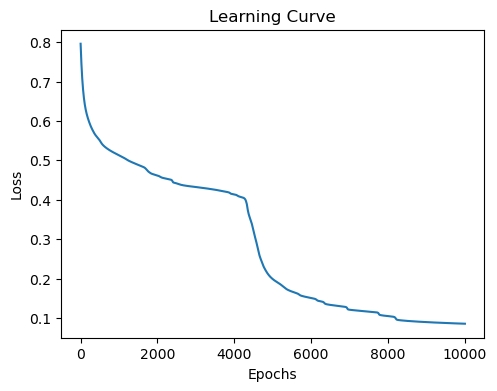

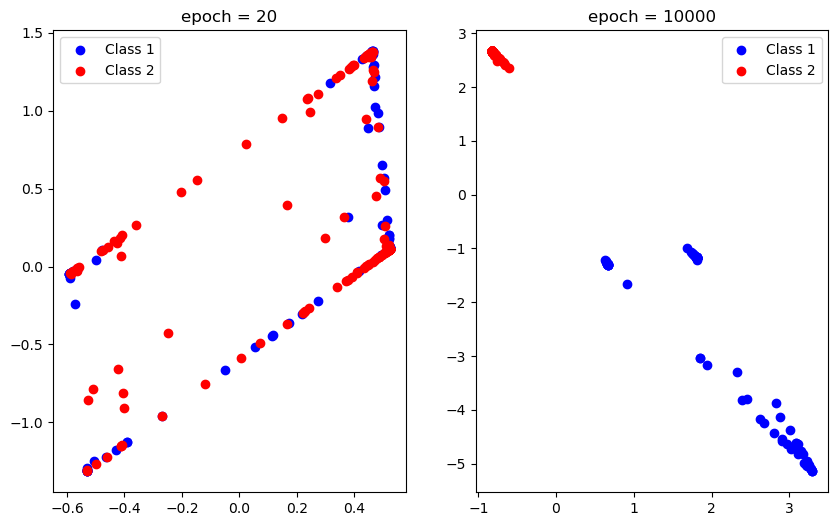

In [20]:
Z = 'Z3'
# Plot the learning curve (loss over epochs)
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(range(len(loss_history)), loss_history)
plt.title("Learning Curve")
plt.xlabel("Epochs")
plt.ylabel("Loss")

# Create a scatter plot with class labels
plt.figure(figsize=(10, 6))
# Plot points for class 'g' (good)

X_class1 = cache20[Z][:, np.where(Y_train == 0)[0]]
X_class2 = cache20[Z][:, np.where(Y_train == 1)[0]]

plt.subplot(1, 2, 1)
plt.title("epoch = 20")
plt.scatter(X_class1[0], X_class1[1], c='b', label='Class 1')
plt.scatter(X_class2[0], X_class2[1], c='r', label='Class 2')
plt.legend()

X_class1 = cache_train[Z][:, np.where(Y_train == 0)[0]]
X_class2 = cache_train[Z][:, np.where(Y_train == 1)[0]]

plt.subplot(1, 2, 2)
plt.title("epoch = 10000")
plt.scatter(X_class1[0], X_class1[1], c='b', label='Class 1')
plt.scatter(X_class2[0], X_class2[1], c='r', label='Class 2')

# Show the plot
plt.legend()
plt.show()

